# Validation

mom  12
6Net model is loading
(1, 32, 32, 32)
7016.0 brain size 22404 is prediction size 


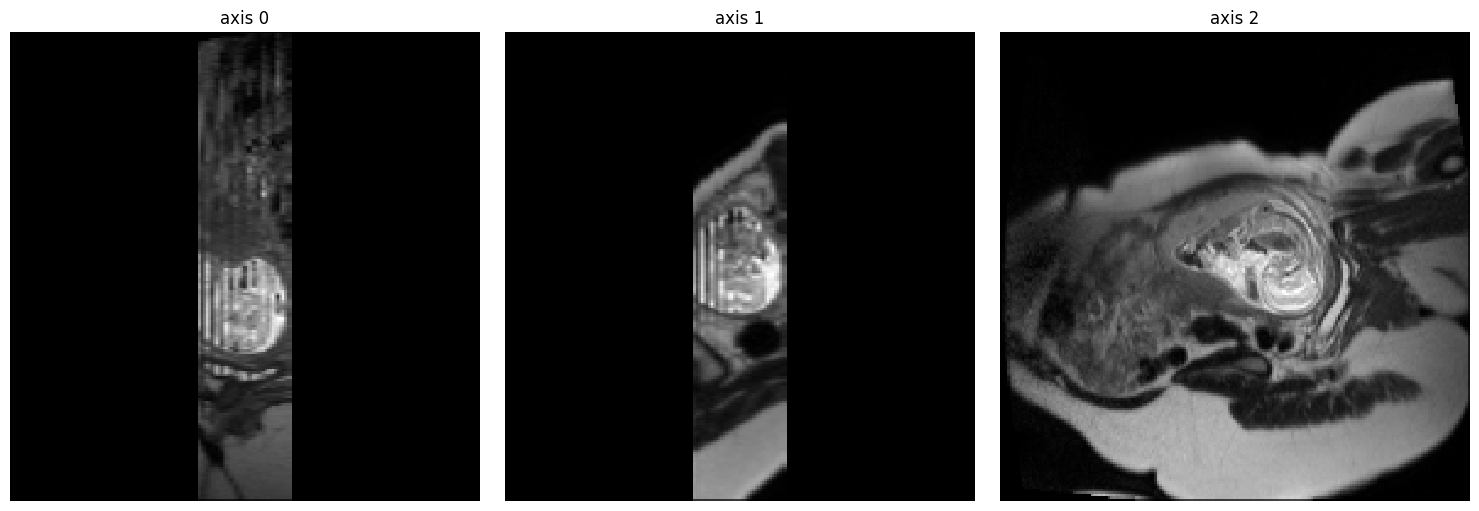

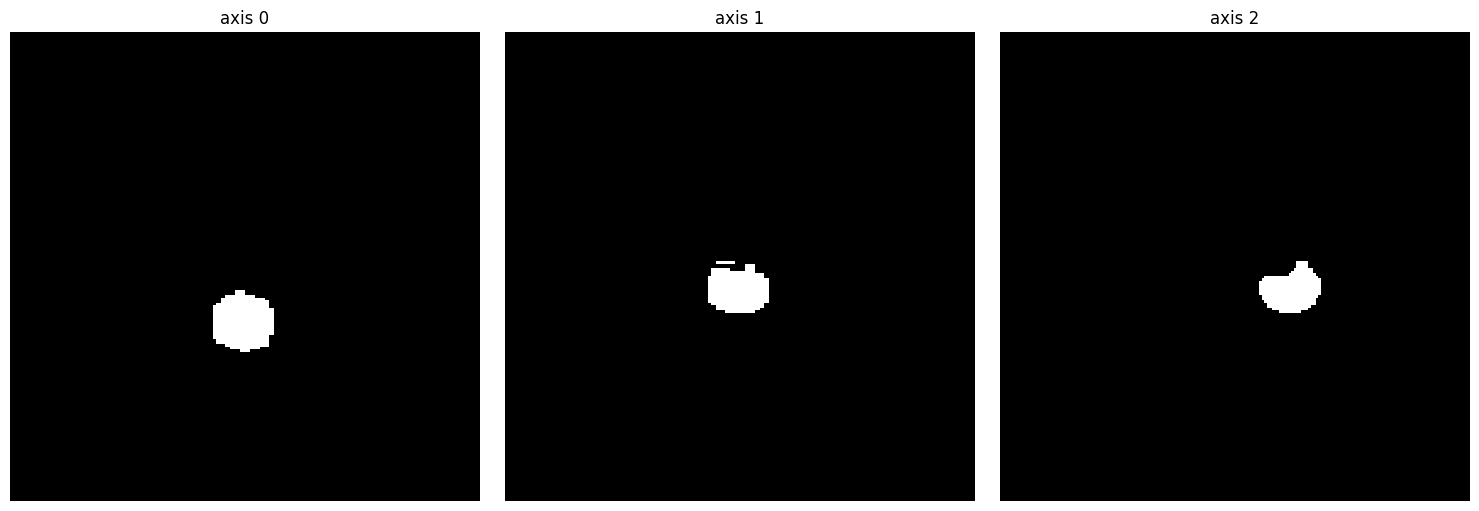

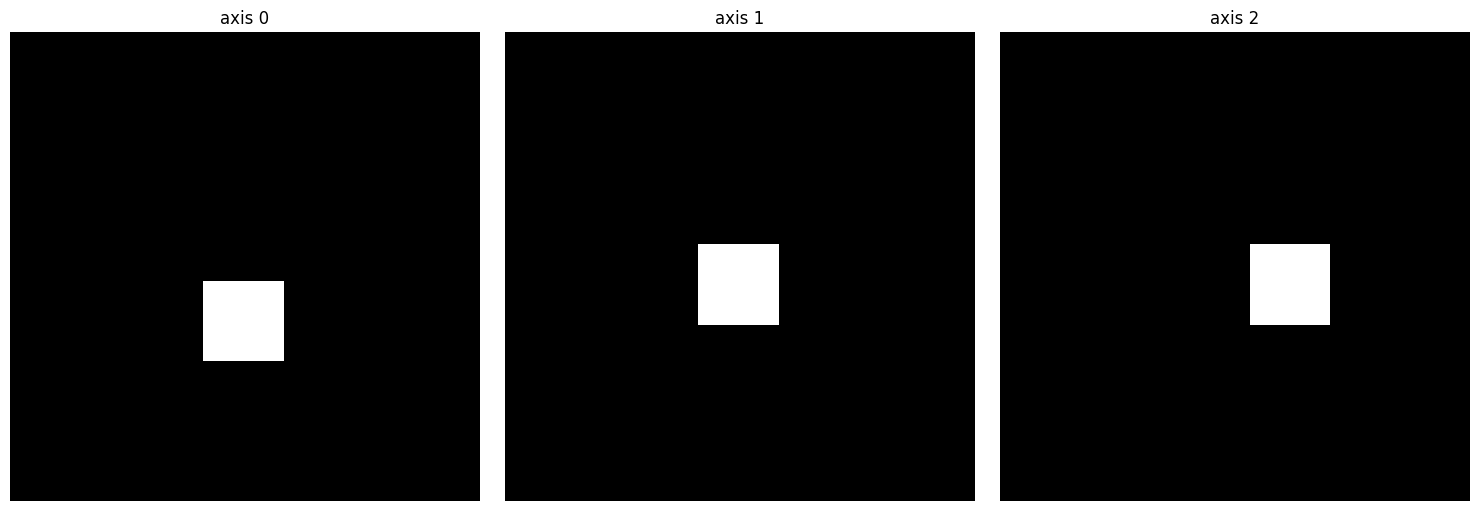

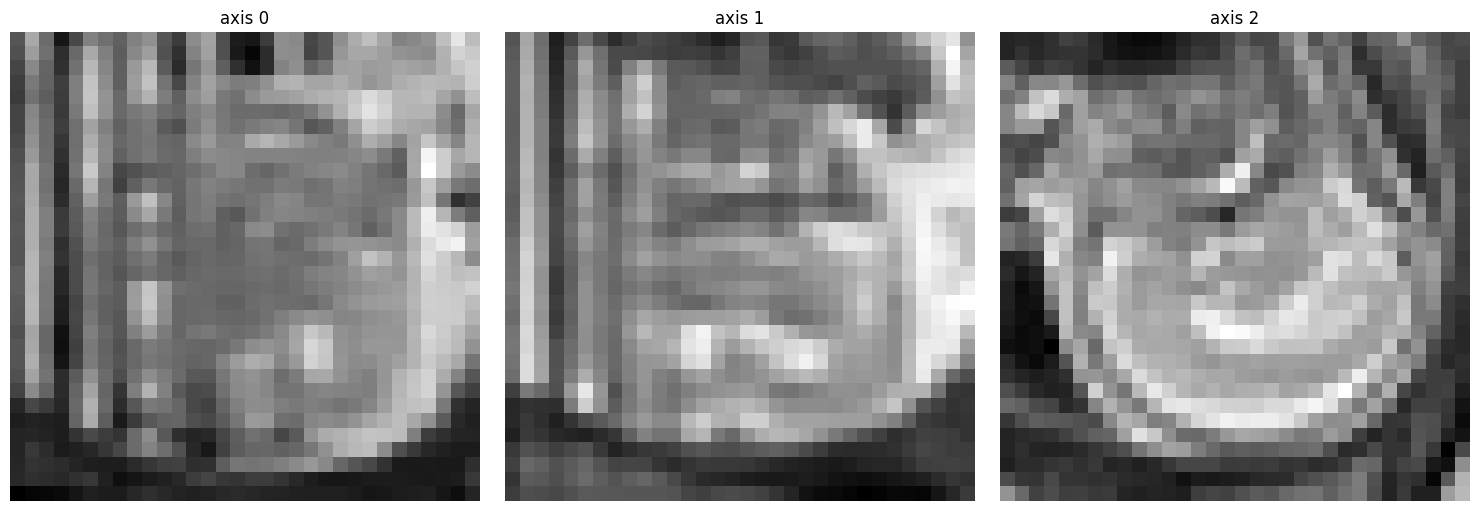

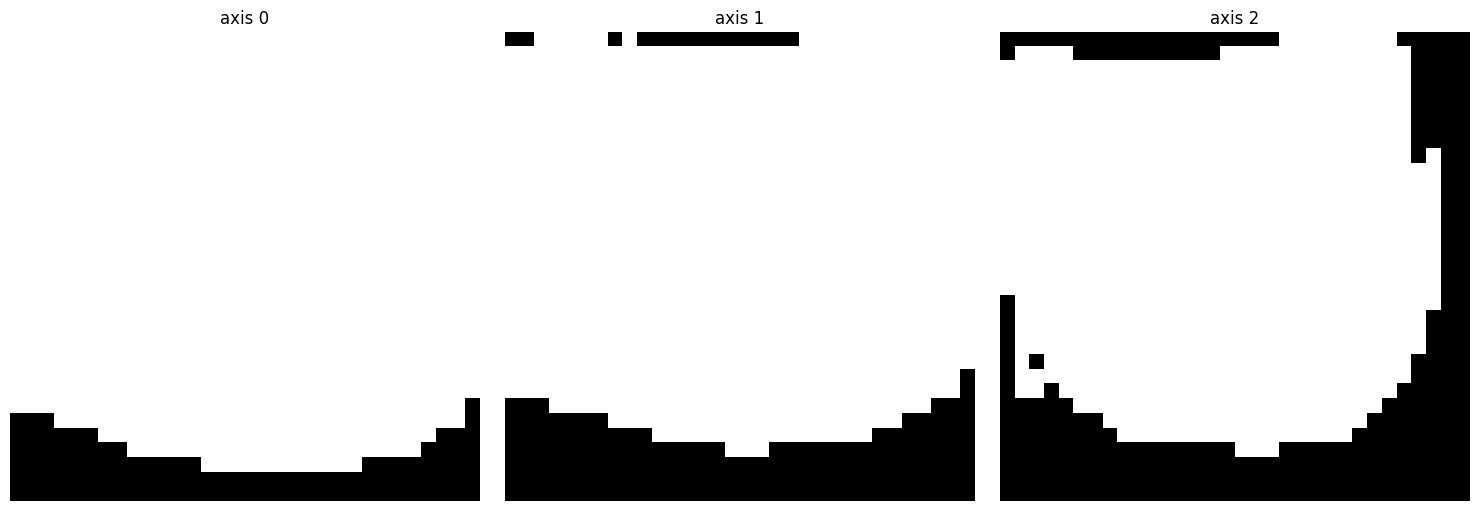

In [22]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm
from utils import *
from help import *

import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

validation_folder_path="validation"
models=["6Net","12Net","24Net","48Net","gmm"]
model=models[0]

random=False
full_random=True

mom_ids , images, masks , b2_images, b3_images, b2_masks, b3_masks = load_val(validation_folder_path) 
image_index = 5
print("mom ", mom_ids[image_index])
img = images[image_index]
mask=masks[image_index]
   
cube , box, combined_model = get_cube_and_model(model,img, mask,random, full_random) 
cube=cube[None,...,None]

prediction_one_hot = combined_model.predict(cube, verbose=0)
prediction = np.argmax(prediction_one_hot,axis=-1)
# prediction = find_largest_component(prediction[0])
print(prediction.shape)
# print("### 6Net Hard dice: ", my_hard_dice(prediction, mask.data))
print(np.sum(mask),"brain size", np.sum(prediction), "is prediction size ")
mean_slice_numbers = tuple(np.median(indices) for indices in np.where(mask != 0))
ne.plot.volume3D(img,slice_nos=mean_slice_numbers);
ne.plot.volume3D(mask,slice_nos=mean_slice_numbers);
mean_slice_numbers = tuple(np.median(indices) for indices in np.where(box != 0))
ne.plot.volume3D(box,slice_nos=mean_slice_numbers);
ne.plot.volume3D(cube);
ne.plot.volume3D(prediction);

    


In [24]:
# def compute_weights(length):
#     """
#     Compute weights for the masks, where earlier masks have higher weights.
    
#     Args:
#     length (int): Number of masks.
    
#     Returns:
#     list of float: Weights for each mask.
#     """
#     weights = np.linspace(1, 0.5, length)
#     weights = weights / np.sum(weights)
#     return weights.tolist()
# weights = compute_weights(4)
# print(weights)
from itertools import combinations

margins_list = [(1 if i in comb else 0 for i in range(4)) for comb in combinations(range(4), 2)]




print(margins_list)

[<generator object <listcomp>.<genexpr> at 0x14b2005784a0>, <generator object <listcomp>.<genexpr> at 0x14b200578430>, <generator object <listcomp>.<genexpr> at 0x14b2005783c0>, <generator object <listcomp>.<genexpr> at 0x14b200578e40>, <generator object <listcomp>.<genexpr> at 0x14b200578f90>, <generator object <listcomp>.<genexpr> at 0x14b200578510>]


# Cascade Brain Identification

# Level 1 : 48 Unet

In [2]:
positions_48, indices_48 = generate_position_map((192,192,192), param_3d.img_size_48,16)
model=models[3]
image_index = 5
img = images[image_index]
mask=masks[image_index]
number_of_valid = 0 
# min_size=7016
min_size=7000
max_size=52278
cube , box, combined_model = get_cube_and_model(model,img, mask,random, full_random) 
valid_position_index_48=None
# cube_48 = None
for i in range(len(positions_48)):
    x1, y1, z1, x2, y2, z2 = positions_48[i]
    cube = extract_cube(img.data,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_48 )
    cube=cube[None,...,None]
    prediction_one_hot = combined_model.predict(cube, verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = find_largest_component(prediction[0])
    non_zero_count = np.count_nonzero(prediction)
    if  min_size <= non_zero_count and is_centered_in_plane(prediction,margins=(35, 25, 10, 35)):# <= max_size:# and is_centered_in_plane(prediction,margin=1):

        print(non_zero_count)
        print(x2-x1,y2-y1,z2-z1)
        cube_48 = extract_cube(img.data, x1, y1, z1, x2, y2, z2 ,cube_size=param_3d.img_size_48 )
        mask_48 = extract_cube(mask.data,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_48 )
        valid_position_index_192 = (x1, y1, z1, x2, y2, z2)

        ms = np.mean(np.column_stack(np.nonzero(mask_48)), axis=0).astype(int)
        ne.plot.volume3D(cube_48,slice_nos=ms);
        ne.plot.volume3D(mask_48,slice_nos=ms);
        ne.plot.volume3D(prediction,slice_nos=ms);
        summed_projection_axis2 = np.sum(prediction, axis=2)

        break

    

48Net model is loading


2024-06-19 22:16:51.980854: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 52.09MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-19 22:16:51.980953: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-19 22:16:51.980982: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-19 22:16:51.981008: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (

NotFoundError: Graph execution error:

Detected at node 'model_1/unet/unet_enc_conv_0_1/Conv3D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 701, in start
      self.io_loop.start()
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
      await result
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/scratch/4594314/ipykernel_1855173/201213395.py", line 17, in <module>
      prediction_one_hot = combined_model.predict(cube, verbose=0)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model_1/unet/unet_enc_conv_0_1/Conv3D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model_1/unet/unet_enc_conv_0_1/Conv3D}}]] [Op:__inference_predict_function_4712]

# Level 2 : 24 Unet

In [1]:
def find_brain_24(positions, min_size, max_size,combined_model , img_48,mask_48,valid_position_index_192, img,mask):
    detection = False
    pred_48 = np.zeros_like(mask_48)
    pred_192 = np.zeros_like(mask)

    valid_position_index_48 = None
    for i in range(len(positions)):
        x1, y1, z1, x2, y2, z2 = positions[i]
        cube = extract_cube(img_48,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_24 )
        cube=cube[None,...,None]
        prediction_one_hot = combined_model.predict(cube, verbose=0)
        prediction = np.argmax(prediction_one_hot,axis=-1)
    
        prediction = ndimage.binary_fill_holes(prediction[0]).astype(int)
        prediction[prediction != 0] = 1

        non_zero_count = np.count_nonzero(prediction)
        if  min_size <= non_zero_count and is_centered_in_plane(prediction,margins=(12, 10, 15, 12)):
            print(non_zero_count)
            cube_24 = extract_cube(img_48, x1, y1, z1, x2, y2, z2 ,cube_size=param_3d.img_size_24 )
            mask_24 = extract_cube(mask_48,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_24 )
            valid_position_index_48 = (x1, y1, z1, x2, y2, z2)

            ms = np.mean(np.column_stack(np.nonzero(mask_48)), axis=0).astype(int)
            
            pred_48[x1:x2, y1:y2, z1:z2] = prediction
            x1, y1, z1, x2, y2, z2 = valid_position_index_192
            pred_192[x1:x2, y1:y2, z1:z2]=pred_48
            ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)

            ne.plot.volume3D(img,slice_nos=ms);
            ne.plot.volume3D(pred_192,slice_nos=ms);
    
            detection = True
            break
    return detection, pred_48 , valid_position_index_48, cube_24 , pred_192
    

positions_24, indices_24 = generate_position_map((param_3d.img_size_48,)*3, param_3d.img_size_24, 8)
combined_model_24 = get_model(models[2]) 
min_size=28000
detection, mask_48 , valid_position_index_48, cube_24 ,  pred_192= find_brain_24(positions_24, min_size, max_size,combined_model_24 , cube_48,mask_48,valid_position_index_192, img,mask)


NameError: name 'generate_position_map' is not defined

In [4]:
valid_position_index_192

(32, 32, 0, 160, 160, 128)

# Level 3: 12 Unet

12Net model is loading
87897


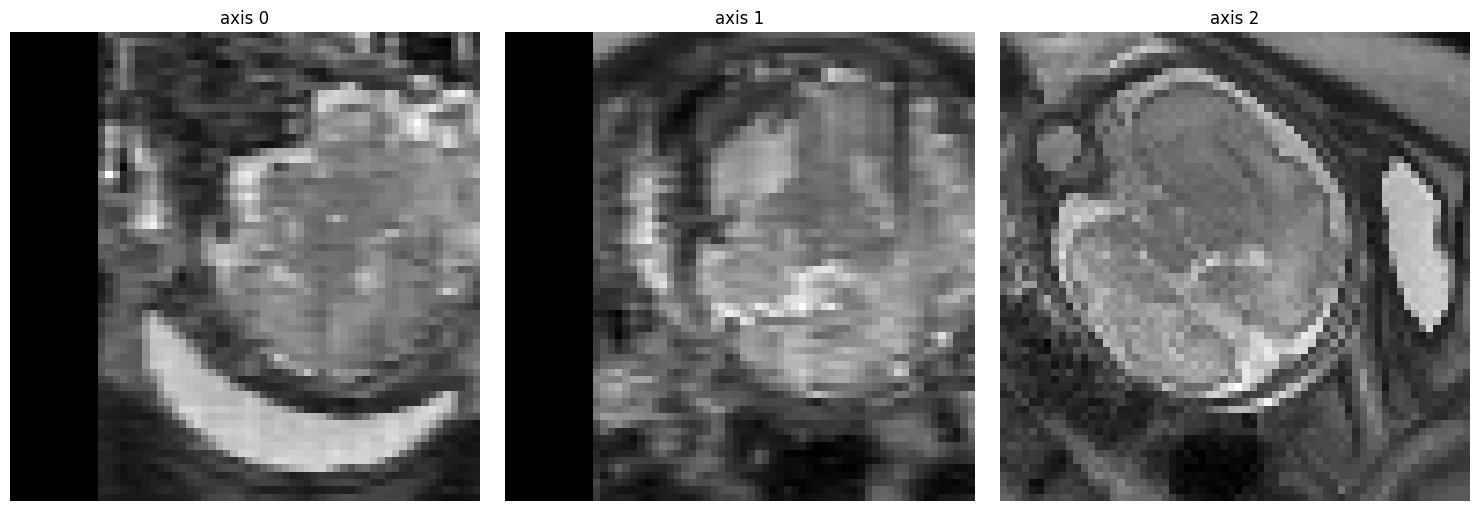

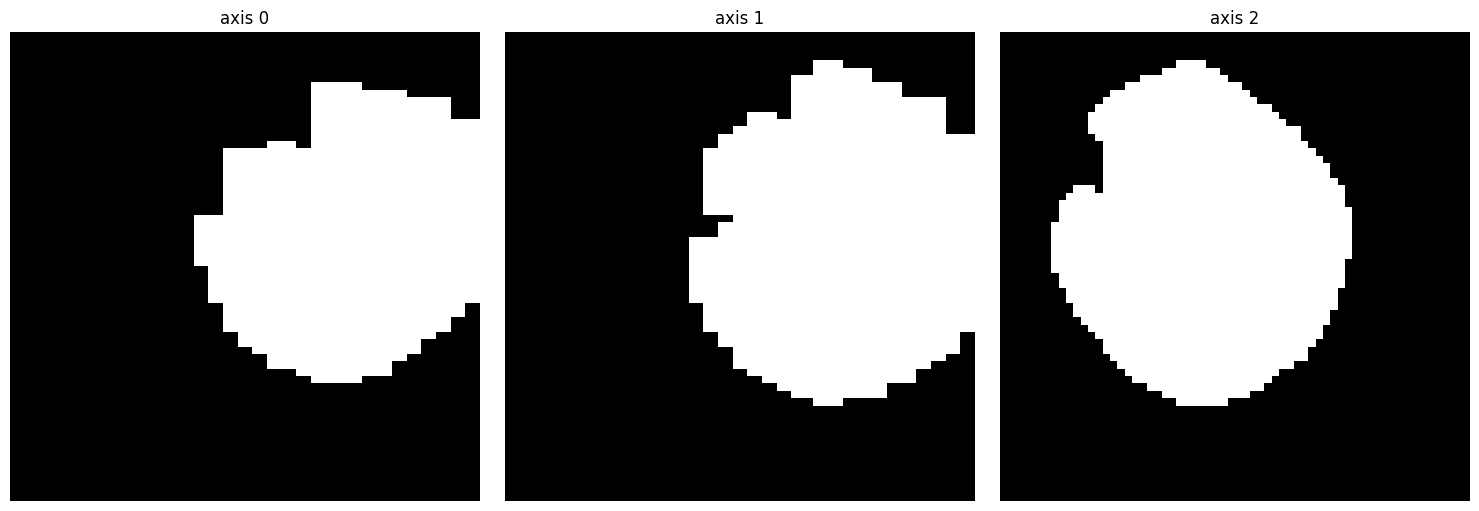

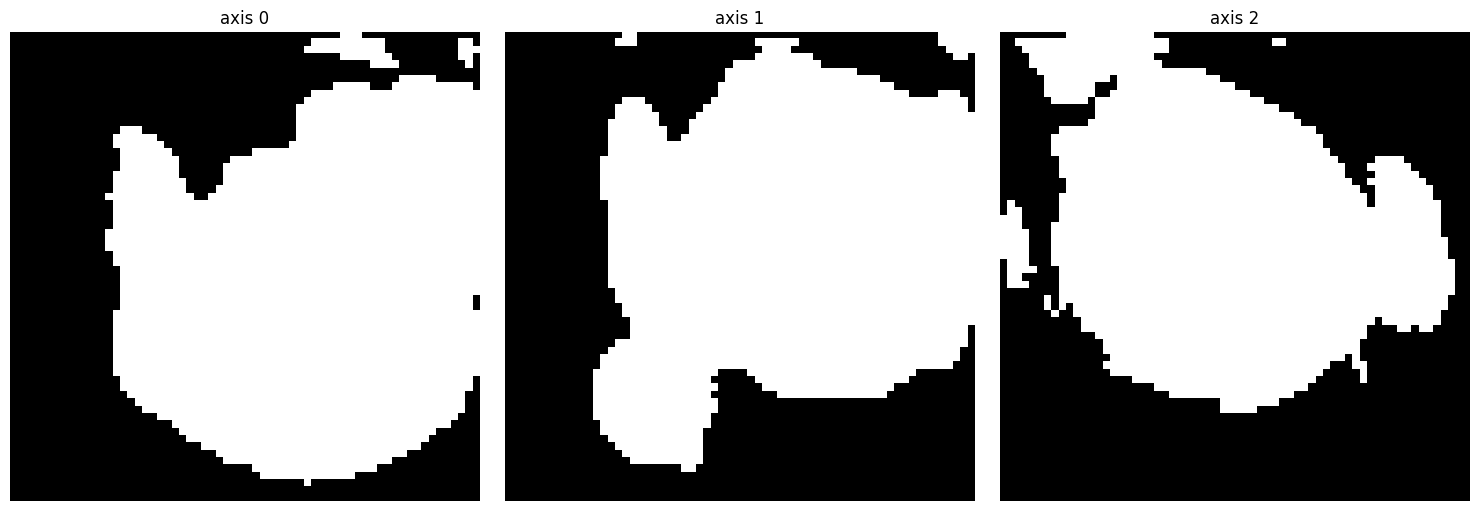

found a position! (64, 64, 64)


In [98]:
from scipy.ndimage import label, find_objects
from scipy.ndimage import center_of_mass

positions_12, indices_12 = generate_position_map((param_3d.img_size_24,)*3, param_3d.img_size_12, 8)
model=models[1]
min_size=4000
combined_model = get_model(model) 
# valid_position_index_24=None
# cube_12 = None

    
for i in range(len(positions_12)):
    x1, y1, z1, x2, y2, z2 = positions_12[i]
    cube = extract_cube(cube_24,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_12 )
    cube=cube[None,...,None]
    prediction_one_hot = combined_model.predict(cube, verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    # ne.plot.volume3D(prediction);
    # prediction = find_largest_component(prediction[0])
    prediction = prediction[0]
    non_zero_count = np.count_nonzero(prediction)
    if min_size <= non_zero_count and is_centered_in_plane(prediction,margins=(0, 1, 0,1)):

        print(non_zero_count)
        number_of_valid += 1
        cube_12 = extract_cube(cube_24,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_12 )
        mask_12 = extract_cube(mask_24,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_12 )
        
        ms = np.mean(np.column_stack(np.nonzero(mask_12)), axis=0).astype(int)
        ne.plot.volume3D(cube_12,slice_nos=ms);
        ne.plot.volume3D(mask_12,slice_nos=ms);
        ne.plot.volume3D(prediction,slice_nos=ms);
        # print("prediction mean coordinates",ms2)
        print("found a position!",cube[0,...,0].shape)

        break

# Level 4: 6 Unet

6Net model is loading
17586


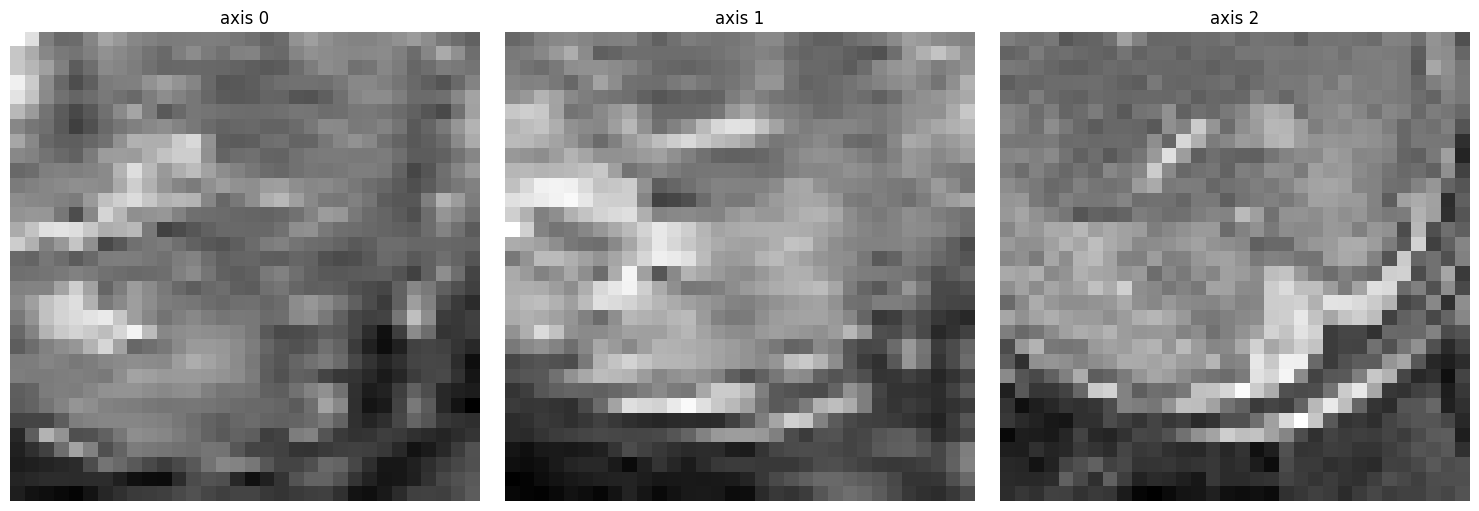

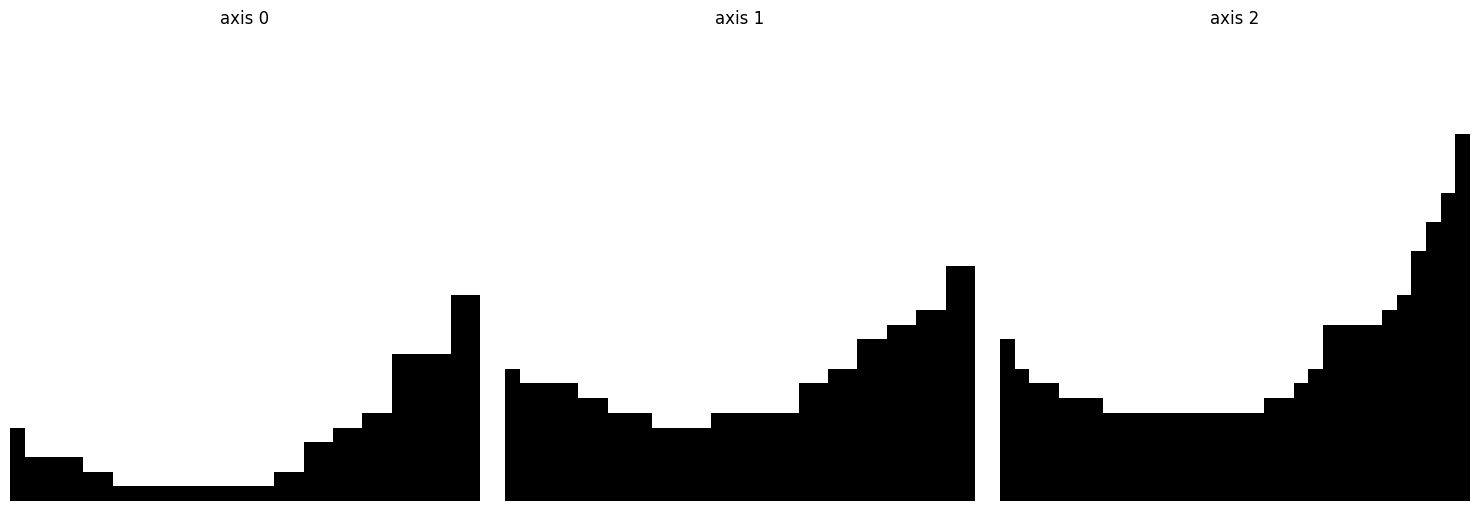

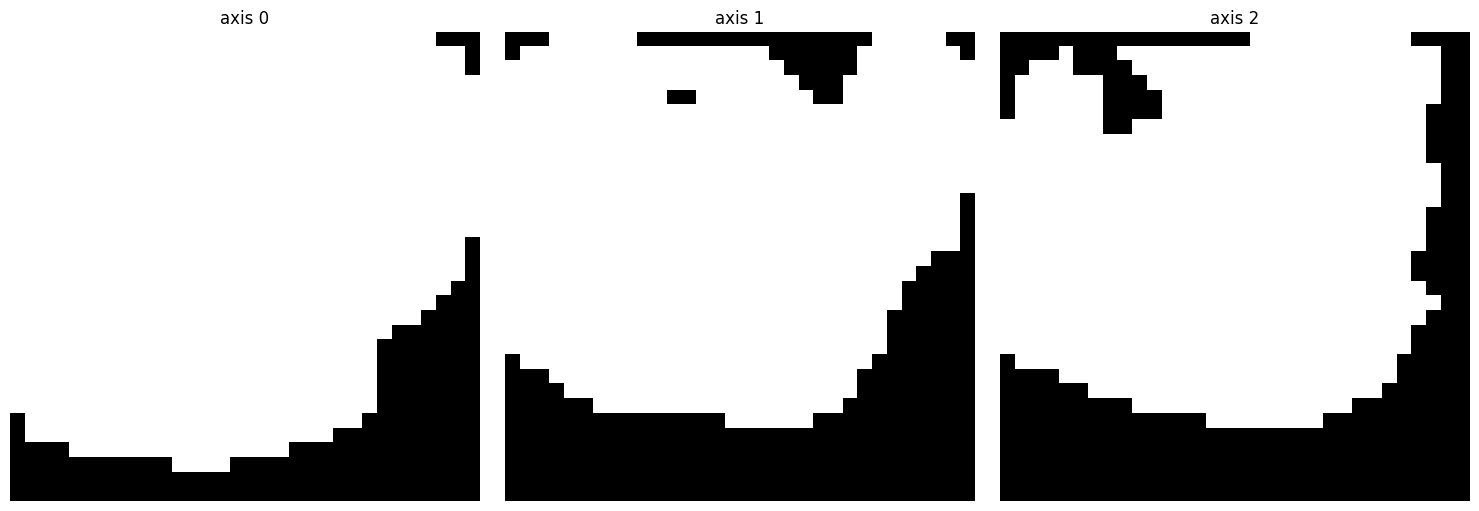

found a position! (32, 32, 32)
14469


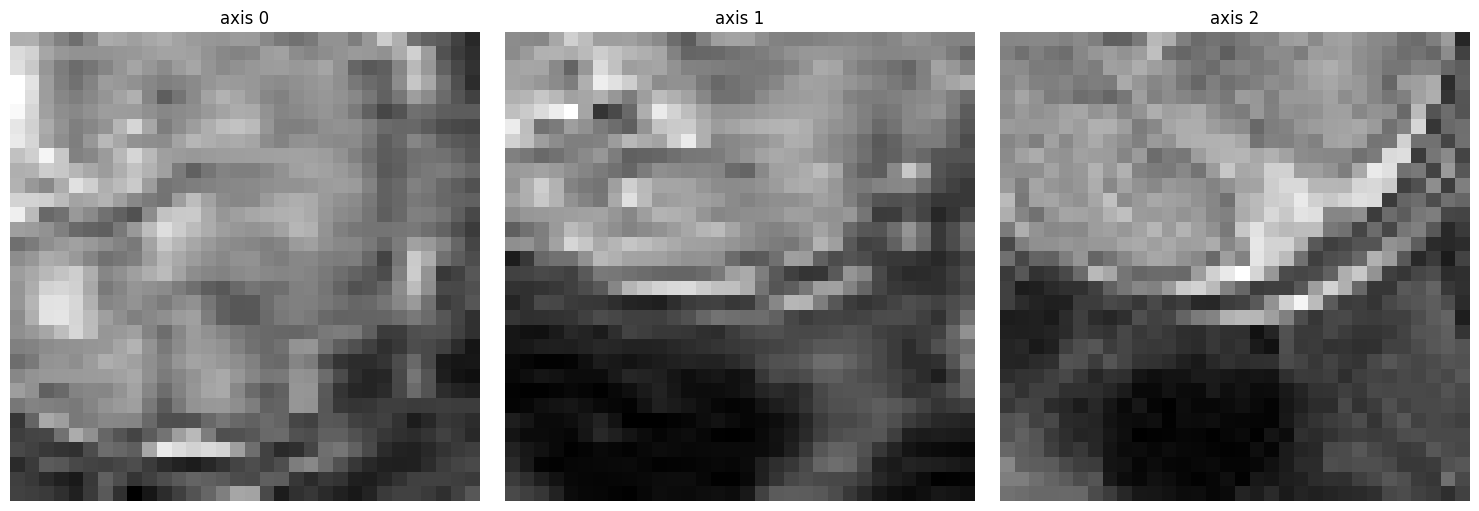

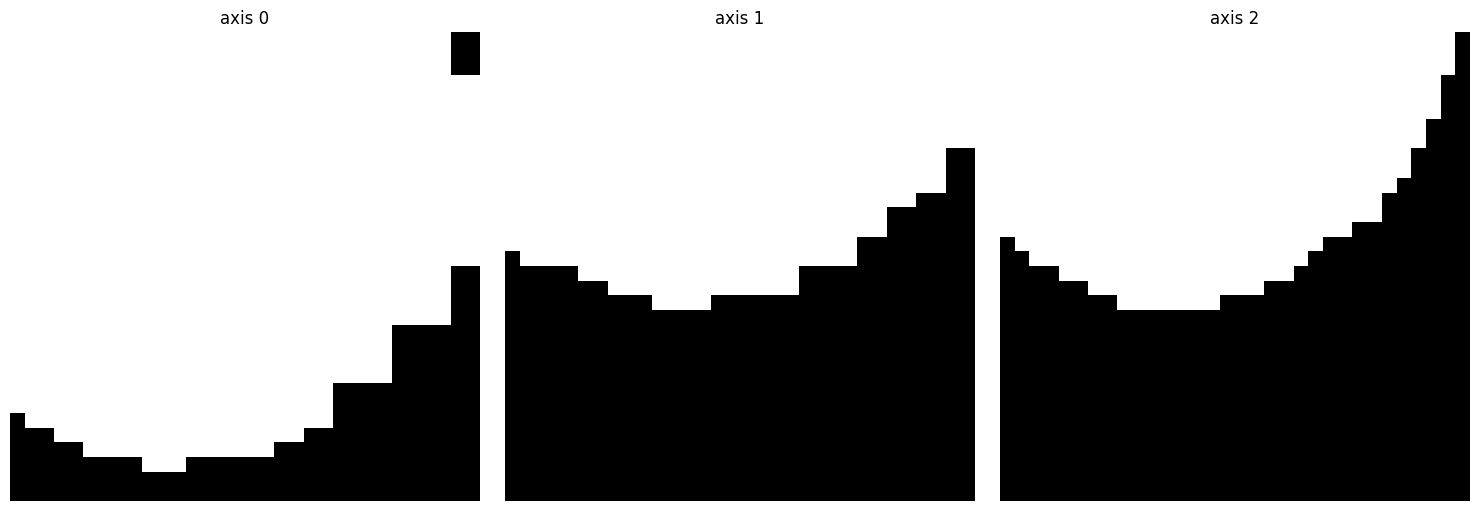

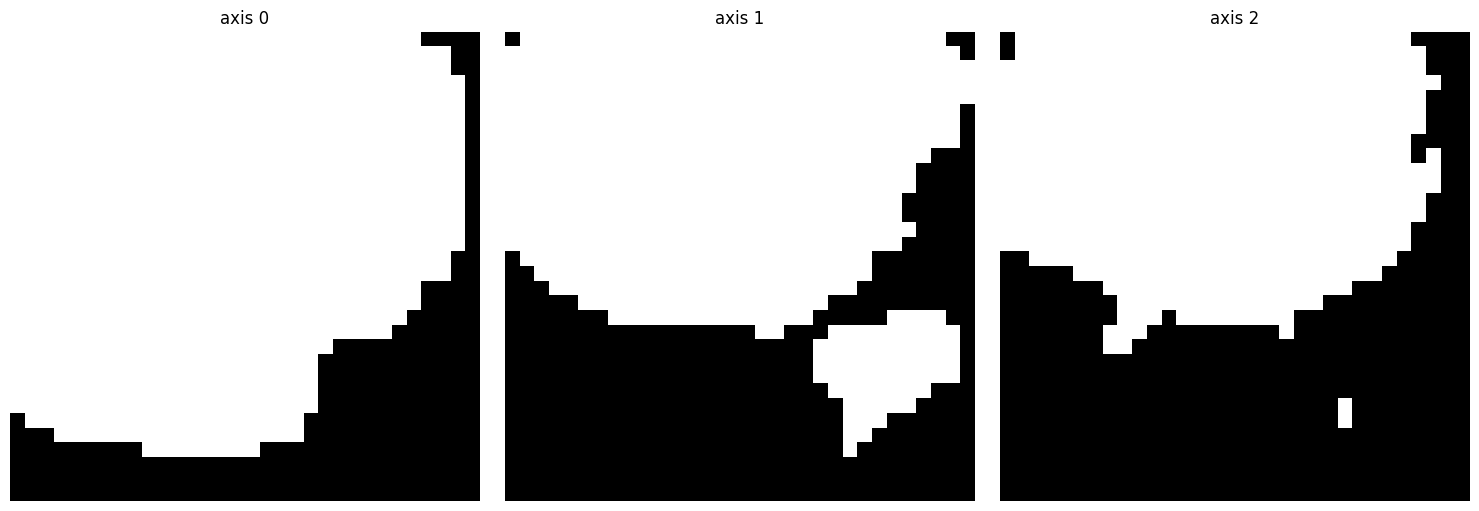

found a position! (32, 32, 32)


In [117]:
from scipy.ndimage import label, find_objects
from scipy.ndimage import center_of_mass

positions_6, indices_6 = generate_position_map((param_3d.img_size_12,)*3, param_3d.img_size_6, 8)
model=models[0]
min_size=12000
combined_model = get_model(model) 
# valid_position_index_24=None
# cube_12 = None

number_of_detections=0
for i in range(len(positions_6)):
    x1, y1, z1, x2, y2, z2 = positions_6[i]
    cube = extract_cube(cube_12,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_6 )
    cube=cube[None,...,None]
    prediction_one_hot = combined_model.predict(cube, verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    # ne.plot.volume3D(prediction);
    # prediction = find_largest_component(prediction[0])
    prediction = prediction[0]
    non_zero_count = np.count_nonzero(prediction)
    if min_size <= non_zero_count and is_centered_in_plane(prediction,margins=(0, 1, 0,1)):

        print(non_zero_count)
        number_of_valid += 1
        cube_6 = extract_cube(cube_12,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_6 )
        mask_6 = extract_cube(mask_12,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_6 )
        ms = np.mean(np.column_stack(np.nonzero(mask_6)), axis=0).astype(int)

        ne.plot.volume3D(cube_6,slice_nos=ms);
        ne.plot.volume3D(mask_6,slice_nos=ms);
        ne.plot.volume3D(prediction,slice_nos=ms);
        # ms2 = np.mean(np.column_stack(np.nonzero(prediction)), axis=0).astype(int)
        # print("prediction mean coordinates",ms2)
        print("found a position!",cube[0,...,0].shape)
        number_of_detections +=1
        if number_of_detections ==5:
            break

In [279]:
np.sum(mask_12)

33571.0

In [106]:
prediction.shape

(32, 32)

In [80]:
cube.shape

(1, 64, 64, 64, 1)